# ACTIVITY: A CLASSIFIER

The goal of this activity is to practice building and discussing a classifier. By the end of the activity, you should be able to justify your design decisions according to 

TASK:

In [1]:
import kagglehub
import os
import pandas as pd
from pathlib import Path

path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
print(os.listdir(path))
df = pd.read_csv(Path(path) / "bbc-news-data.csv", sep='\t')

100%|██████████| 1.81M/1.81M [00:01<00:00, 1.43MB/s]

Extracting files...


['bbc-news-data.csv']


In [2]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [3]:
df.describe()

,category,filename,title,content
count,2225,2225,2225,2225
unique,5,511,2096,2092
top,sport,001.txt,Microsoft seeking spyware trojan,Microsoft has warned PC users to update their...
freq,511,5,2,2


## Baseline classifier

We will start with a baseline classifier. It is a simple Bag-of-words classifier.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.95      0.97      0.96       115
entertainment       0.97      0.94      0.96        72
     politics       0.96      0.95      0.95        76
        sport       0.99      0.99      0.99       102
         tech       0.95      0.95      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



## PART 1: preparation

Answer the questions below as comments in the following cell. In your answers, avoid using common sense. Use adequate jargons.

In [ ]:
#ex1

# Question 1: What is the underlying premise of the Bag-of-Words classifier, that is, why does BoW allow to classify these texts?
# Question 2: What is the underlying premise of a BERT-based classifier, that is, why should BERT embeddings be interesting to classify these texts?


## Question 1: What is the underlying premise of the Bag-of-Words classifier, that is, why does BoW allow to classify these texts?


**Questão 1**  
A premissa subjacente do classificador Bag-of-Words é que cada texto é representado como um vetor esparso de contagens (ou frequências ponderadas via TF‑IDF) em um espaço vetorial de dimensão igual ao vocabulário. Essa modelagem ignora as relações sintáticas e a ordem das palavras, focando apenas na distribuição estatística de tokens. Modelos discriminativos (como SVM ou Naive Bayes Multinomial) utilizam esses vetores para aprender fronteiras de decisão baseadas em perfis lexicais, pois diferentes classes textuais apresentam distribuições de tokens suficientemente distintas para serem separáveis.

## Question 2: What is the underlying premise of a BERT-based classifier, that is, why should BERT embeddings be interesting to classify these texts?


**Questão 2**  
A premissa subjacente de um classificador baseado em BERT é que embeddings contextuais extraídos de uma arquitetura Transformer bidirecional pré-treinada contêm riqueza semântica e sintática suficiente para discriminar classes textuais. As camadas de multi-head self-attention capturam dependências de longo alcance e nuances de contexto, enquanto o vetor associado ao token [CLS] funciona como uma representação global do texto. No processo de fine-tuning, os parâmetros do modelo são ajustados de forma supervisionada, afinando essas projeções contextuais para maximizar a separabilidade das classes na tarefa de classificação.

## PART 2: action

(a) Make a classifier that uses BERT embeddings to categorize the texts in the dataset we have discussed.

(b) Make a bar plot comparing the accuracy of the BERT-based classifier to that of the Bag-of-Words classifier

(c) Use a PCA or a T-SNE plot to visualize the documents in the newsgroups dataset in the embedding space provided by BERT. Analyze the plot taking into account the confusion matrix or the classification report of your BERT-based classifier.




## Parte 2: Ações com Classificadores e Visualizações

### Passo 0: Instalar dependências
No seu Jupyter Notebook, execute:
```bash
!pip install transformers torch scikit-learn matplotlib

# Passo 1: Carregar e dividir o dataset

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='all',
                                categories=categories,
                                remove=('headers','footers','quotes'))
data, target, target_names = newsgroups.data, newsgroups.target, newsgroups.target_names

data_train, data_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

# Passo 2: Bag‑of‑Words + Naive Bayes

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer(stop_words='english')
tfidf = TfidfTransformer()

X_counts_train = vectorizer.fit_transform(data_train)
X_tfidf_train  = tfidf.fit_transform(X_counts_train)
X_tfidf_test   = tfidf.transform(vectorizer.transform(data_test))

clf_bow = MultinomialNB()
clf_bow.fit(X_tfidf_train, y_train)
y_pred_bow = clf_bow.predict(X_tfidf_test)
acc_bow = accuracy_score(y_test, y_pred_bow)
print(f"Bag‑of‑Words accuracy: {acc_bow:.4f}")

Bag‑of‑Words accuracy: 0.8557


# Passo 3: BERT Embeddings + Regressão Logística

In [7]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

def embed_texts(texts, batch_size=8, max_len=128):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors='pt',
                        padding=True, truncation=True,
                        max_length=max_len)
        with torch.no_grad():
            out = bert_model(**enc)
        cls_emb = out.last_hidden_state[:,0,:].cpu().numpy()
        embs.append(cls_emb)
    return np.vstack(embs)

X_train_bert = embed_texts(data_train)
X_test_bert  = embed_texts(data_test)

clf_bert = LogisticRegression(max_iter=1000)
clf_bert.fit(X_train_bert, y_train)
y_pred_bert = clf_bert.predict(X_test_bert)
acc_bert = accuracy_score(y_test, y_pred_bert)
print(f"BERT-based classifier accuracy: {acc_bert:.4f}")

BERT-based classifier accuracy: 0.8006


# Passo 4: Comparativo de Acurácia

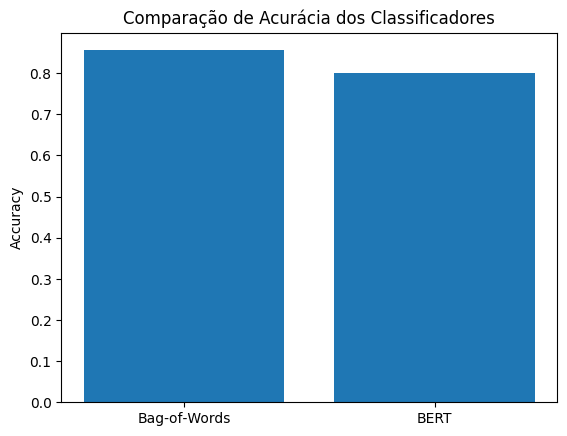

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(['Bag‑of‑Words','BERT'], [acc_bow, acc_bert])
plt.ylabel('Accuracy')
plt.title('Comparação de Acurácia dos Classificadores')
plt.show()